In [ ]:
def get_df(name):
    """
    This function takes in the string
    'items', 'stores', or 'sales' and
    returns a df containing all pages and
    creates a .csv file for future use.
    """
    base_url = 'https://python.zach.lol'
    api_url = base_url + '/api/v1/'
    response = requests.get(api_url + name)
    data = response.json()
    
    # create list from 1st page
    my_list = data['payload'][name]
    
    # loop through the pages and add to list
    while data['payload']['next_page'] != None:
        response = requests.get(base_url + data['payload']['next_page'])
        data = response.json()
        my_list.extend(data['payload'][name])
    
    # Create DataFrame from list
    df = pd.DataFrame(my_list)
    
    # Write DataFrame to csv file for future use
    df.to_csv(name + '.csv')
    return df

######################### Params Helper function, can be used in big_df ###############################

def get_df_params(name):
    """
    This function takes in the string
    'items', 'stores', or 'sales' and
    returns a df containing all pages and
    creates a .csv file for future use.
    """
    # Create an empty list names `results`.
    results = []
    
    # Create api_url variable
    api_url = 'https://python.zach.lol/api/v1/'
    
    # Loop through the page parameters until an empty response is returned.
    for i in range(3):
        response =  requests.get(items_url, params = {"page": i+1})    
    
        # We have reached the end of the results
        if len(response.json()) == 0:   
            break
            
        else:
            # Convert my response to a dictionary and store as variable `data`
            data = response.json()
        
            # Add the list of dictionaries to my list
            results.extend(data['payload'][name])
    
    # Create DataFrame from list
    df = pd.DataFrame(results)
    
    # Write DataFrame to csv file for future use
    df.to_csv(name + '.csv')
    
    return df


def get_store_data():
    """
    This function checks for csv files
    for items, sales, stores, and big_df 
    if there are none, it creates them.
    It returns one big_df of merged dfs.
    """
    # check for csv files or create them
    if os.path.isfile('items.csv'):
        items_df = pd.read_csv('items.csv', index_col=0)
    else:
        items_df = get_df('items')
        
    if os.path.isfile('stores.csv'):
        stores_df = pd.read_csv('stores.csv', index_col=0)
    else:
        stores_df = get_df('stores')
        
    if os.path.isfile('sales.csv'):
        sales_df = pd.read_csv('sales.csv', index_col=0)
    else:
        sales_df = get_df('sales')
        
    if os.path.isfile('big_df.csv'):
        df = pd.read_csv('big_df.csv', index_col=0)
        return df
    else:
        # merge all of the DataFrames into one
        df = pd.merge(sales_df, stores_df, left_on='store', right_on='store_id').drop(columns={'store'})
        df = pd.merge(df, items_df, left_on='item', right_on='item_id').drop(columns={'item'})

        # write merged DateTime df with all data to directory for future use
        df.to_csv('big_df.csv')
        return df

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [ ]:
df = get_store_data()

In [ ]:
# def prep(df):
#     df['sale_date'] = pd.to_datetime(df.sale_date, format='%a, %d %b %Y %H:%M:%S %Z')
#     df = df.set_index('sale_date').sort_index()
#     df['month'] = df.index.month
#     df['day_of_week'] = df.index.dayofweek
#     df['sales_total'] = df.sale_amount * df.item_price
#     return df

In [ ]:
# df = prep(df)

In [ ]:
# df.head()

In [ ]:
# sort values by date
# create dollars sold
# sale_amount to be items_sold
# aggregate daily by summing the values
# set index to date
def prep_data(df):
    return (df.assign(ds = pd.to_datetime(df.sale_date)).
            # sort values by date
            sort_values('ds').
            # create dollars sold
            assign(dollars_sold = df.sale_amount * df.item_price).
            # sale_amount to be items_sold
            assign(items_sold = df.sale_amount).
            # aggregate daily by summing the values
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().
            # set index to date
            reset_index().set_index('ds'))

df = prep_data(df)


In [ ]:
df.head().T

In [ ]:
# remove leap days

df = df[df.index != '2016-02-29']

# Split

- We will use the training proportion method to split.
- Identify the total length of the dataframe and multiple by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
- Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
- Return train and test dataframes.

In [ ]:
train_size = int(len(df) * .5)
train_size

In [ ]:
validate_size = int(len(df) * .3)

In [ ]:
test_size = int(len(df) - train_size - validate_size)

In [ ]:
validate_end_index = train_size + validate_size

Use those values to split our dataframe

In [ ]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

Verify Splits

In [ ]:
print(len(train) + len(validate) + len(test) == len(df))

In [ ]:
print(df.head(1) == train.head(1))

In [ ]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

In [ ]:
pd.concat([test.tail(1), df.tail(1)])


In [ ]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [ ]:
target_var = 'dollars_sold'


In [ ]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to compare performance

In [ ]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [ ]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [ ]:
eval_df

# Forecast

- Forecasting is another word for predicting time series data

**Last observed value**

- Make Predictions

In [ ]:
dollars = round(train['dollars_sold'][-1:][0], 2)
dollars

In [ ]:
items = train['items_sold'][-1:][0]
items

In [ ]:
yhat_df = pd.DataFrame({'dollars_sold': [dollars], 
                        'items_sold': [items]},
                        index = validate.index)

yhat_df.head()
yhat_df.describe()

**Plot Actual vs. Predicted Values**

In [ ]:
plot_and_eval('dollars_sold')

In [ ]:
for col in train.columns:
    plot_and_eval(col)

# Evaluate

- Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_ovserved_value',
               target_var = col)
eval_df

# Simple Average

- Make Predictions

- Dollars: establishing the value of the prediction we will make

In [ ]:
# compute simple average

# plt.plot(train['dollars_sold'])
dollars = round(train['dollars_sold'].mean(), 2)

In [ ]:
items = round(train['items_sold'].mean(), 2)
items

In [ ]:
# Aplly predictions to our observations

def make_predictions():
    yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           'items_sold': [items]},
                          index= validate.index)
    return yhat_df

In [ ]:
yhat_df = make_predictions()

In [ ]:
yhat_df.describe()

**Plot Actual vs. Predicted**

In [ ]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average',
                            target_var = col)
eval_df

# Moving Average

In [ ]:
# train['dollars_sold'].tail(30)
plt.figure(figsize=(12,4))
plt.plot(train['dollars_sold'].rolling(7).mean())
plt.plot(train['dollars_sold'].rolling(30).mean())
plt.plot(train['dollars_sold'].rolling(90).mean())
plt.plot(train['dollars_sold'].rolling(120).mean())
plt.plot(train['dollars_sold'], alpha=.2)

In [ ]:
# demonstrate the mean of the first 30 days is equal to rolling(30) on day 30



**Make Predictions**


In [ ]:
train['dollars_sold'].head(30).mean()
train['dollars_sold'].rolling(30).mean()

In [ ]:
period = 30

dollars = round(train['dollars_sold'].rolling(period).mean()[-1], 2)
items = round(train['items_sold'].rolling(period).mean()[-1],2)

print(dollars, items)

In [ ]:
yhhat_df = make_predictions()
yhat_df.head()

In [ ]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg',
                            target_var = col)
    
eval_df

In [ ]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    dollars = round(train['dollars_sold'].rolling(1).mean()[-1], 2)
    items = round(train['items_sold'].rolling(1).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
for col in train.columns:
    eval_df = append_eval_df(model_type = model_type,
                        target_var = col)

In [ ]:
eval_df

In [ ]:
min_items_rmse = eval_df[eval_df.target_var == 'items_sold']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

In [2]:
from vega_datasets import data
stocks = data.stocks()

In [3]:
stocks.head()

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45


In [4]:
 df = stocks.pivot_table('price', 'date', 'symbol')

In [5]:
df.head()

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2000-01-01 to 2010-03-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    123 non-null    float64
 1   AMZN    123 non-null    float64
 2   GOOG    68 non-null     float64
 3   IBM     123 non-null    float64
 4   MSFT    123 non-null    float64
dtypes: float64(5)
memory usage: 5.8 KB


In [7]:
df.drop(columns='GOOG', inplace=True)

# Split Data

In [8]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [9]:
train.shape, validate.shape, test.shape

((61, 4), (36, 4), (26, 4))

- Verify splits

In [10]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [11]:
print(df.head(1) == train.head(1))


symbol      AAPL  AMZN   IBM  MSFT
date                              
2000-01-01  True  True  True  True


- Is the last row of train the month before the first row of validate? And the same for validate to test?

In [12]:

pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

symbol,AAPL,AMZN,IBM,MSFT
date,,,,
2008-01-01,135.36,77.70,102.75,31.13
2008-02-01,125.02,64.47,109.64,26.07


- Is the last row of test the same as the last row of our original dataframe?



In [13]:
pd.concat([test.tail(1), df.tail(1)])


symbol,AAPL,AMZN,IBM,MSFT
date,,,,
2010-03-01,223.02,128.82,125.55,28.8
2010-03-01,223.02,128.82,125.55,28.8


Let's plot our data first, viewing where the data is split into train and test.



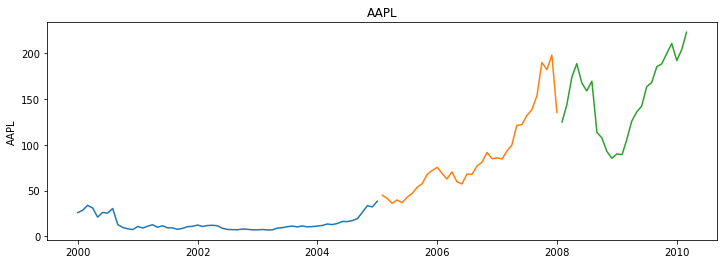

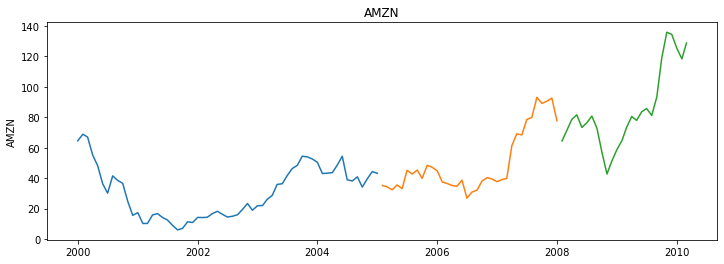

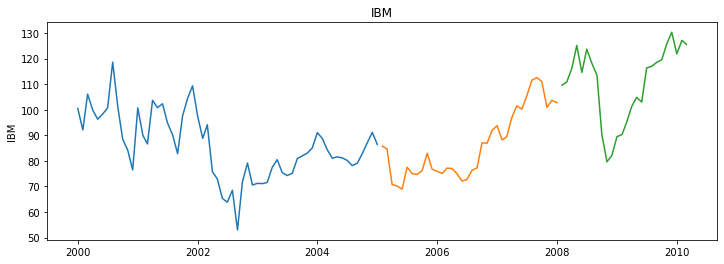

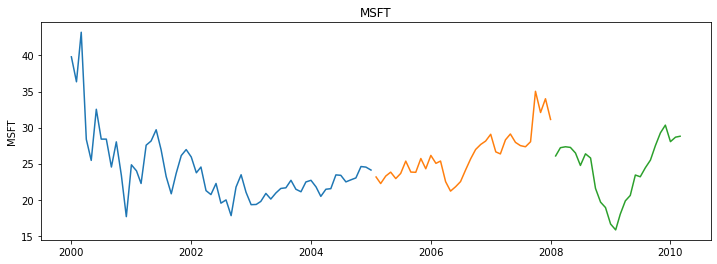

In [14]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

- Before we try out different methods for forecasting stock prices, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.



In [15]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

- plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [16]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

- Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. Which we will create an empty eval_df dataframe object to start.

In [17]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [18]:
eval_df

,model_type,target_var,rmse


# Forecast

**Last Observed Value**

- Make Predictions

In [19]:
apple = train['AAPL'][-1:][0]
ibm = train['IBM'][-1:][0]
amazon = train['AMZN'][-1:][0]
microsoft = train['MSFT'][-1:][0]

yhat_df = pd.DataFrame({'AAPL': [apple], 'AMZN': [amazon], 'IBM': [ibm], 'AMZN': [amazon], 'MSFT': [microsoft] }, 
                       index = validate.index)

yhat_df.head(2)


,AAPL,AMZN,IBM,MSFT
date,,,,
2005-02-01,38.45,43.22,86.39,24.11
2005-03-01,38.45,43.22,86.39,24.11


- Plot Actual vs. Predicted Values

AAPL -- RMSE: 65


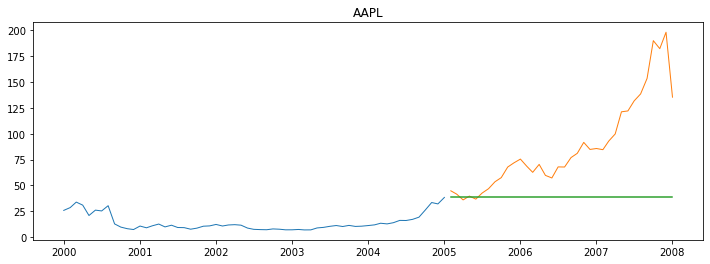

AMZN -- RMSE: 21


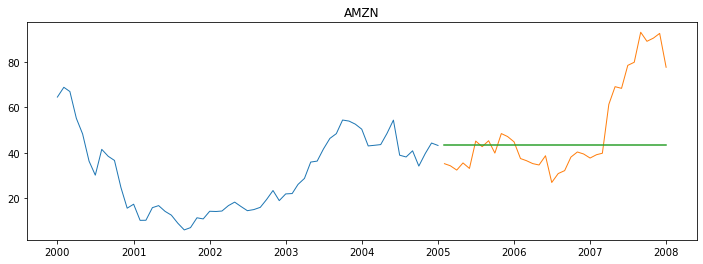

IBM -- RMSE: 13


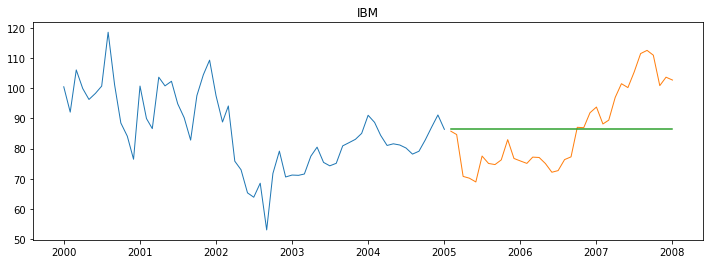

MSFT -- RMSE: 4


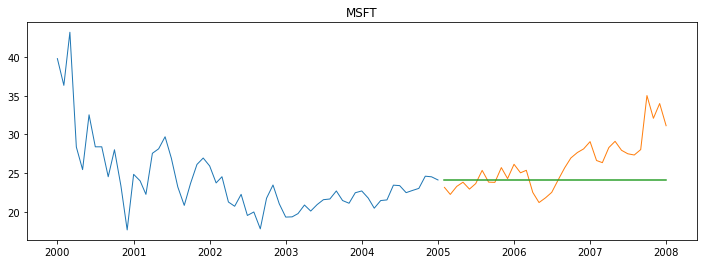

In [20]:
for col in train.columns:
    plot_and_eval(col)

- Evaluate

In [21]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [22]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AAPL,65.0
1,last_observed_value,AMZN,21.0
2,last_observed_value,IBM,13.0
3,last_observed_value,MSFT,4.0


**Simple Average**

- Make Predictions

In [23]:
apple = train['AAPL'].mean()
ibm = train['IBM'].mean()
amazon = train['AMZN'].mean()
microsoft = train['MSFT'].mean()


def make_predictions():
    yhat_df = pd.DataFrame({'AAPL': [apple],
                            'IBM': [ibm],
                            'AMZN': [amazon],
                            'MSFT': [microsoft]
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [24]:
yhat_df.head(2)


,AAPL,IBM,AMZN,MSFT
date,,,,
2005-02-01,14.283443,86.045902,31.136885,24.091475
2005-03-01,14.283443,86.045902,31.136885,24.091475


- Plot Actual vs. Predicted Values



AAPL -- RMSE: 85


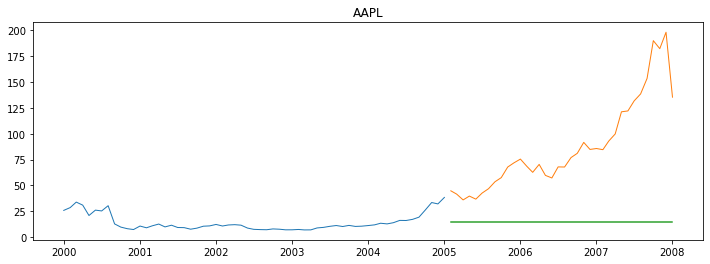

AMZN -- RMSE: 27


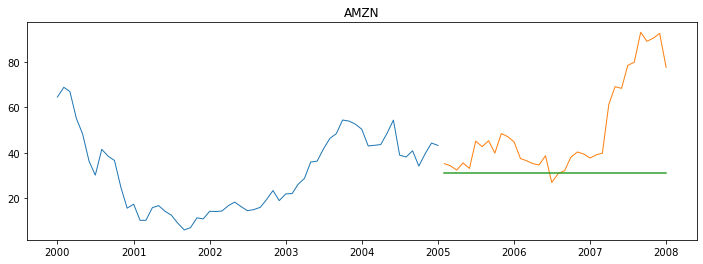

IBM -- RMSE: 13


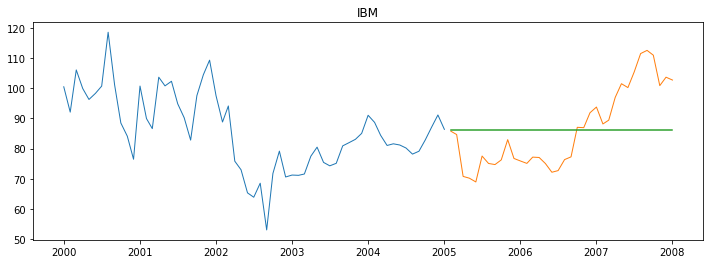

MSFT -- RMSE: 4


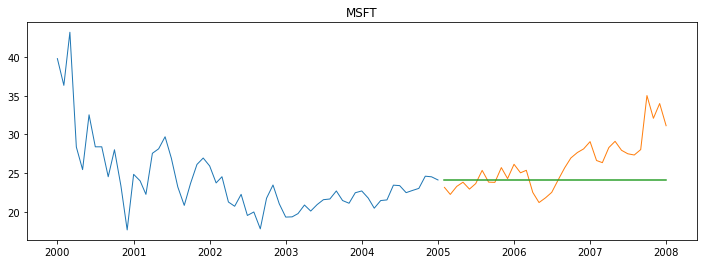

In [25]:
for col in train.columns:
    plot_and_eval(col)

In [26]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

**Moving Average**

- Make Predictions

In [27]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30
apple = train['AAPL'].rolling(period).mean()[-1]
ibm = train['IBM'].rolling(period).mean()[-1]
amazon = train['AMZN'].rolling(period).mean()[-1]
microsoft = train['MSFT'].rolling(period).mean()[-1]


yhat_df = make_predictions()
yhat_df.head(3)

,AAPL,IBM,AMZN,MSFT
date,,,,
2005-02-01,13.762333,78.791333,37.436667,21.713667
2005-03-01,13.762333,78.791333,37.436667,21.713667
2005-04-01,13.762333,78.791333,37.436667,21.713667


- Plot Actual vs. Predicted values

AAPL -- RMSE: 85


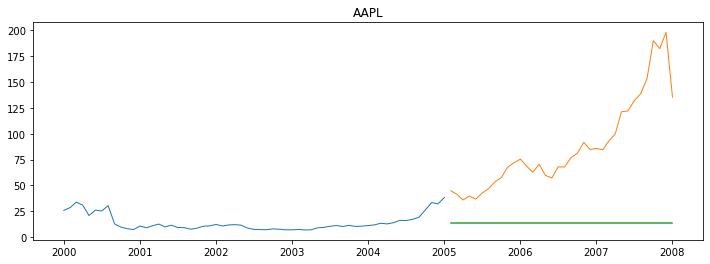

AMZN -- RMSE: 24


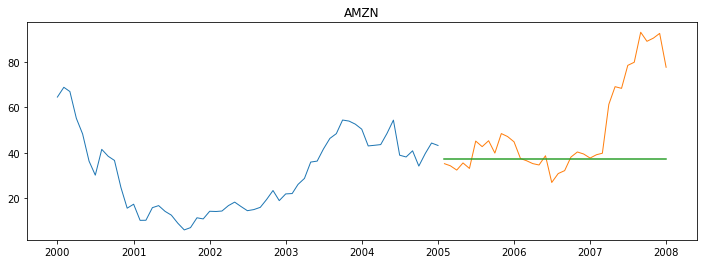

IBM -- RMSE: 15


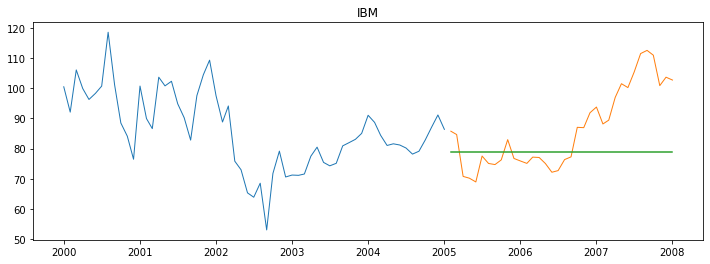

MSFT -- RMSE: 6


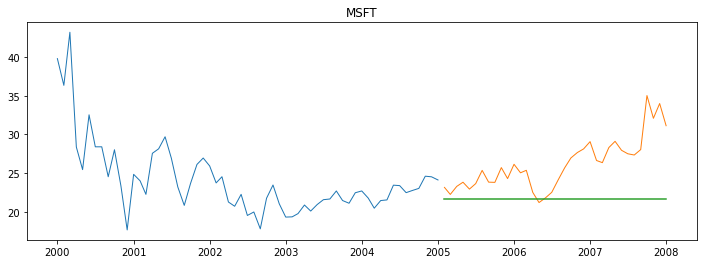

In [28]:
for col in train.columns:
    plot_and_eval(col)

- Evaluate

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

In [30]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AAPL,65.0
1,last_observed_value,AMZN,21.0
2,last_observed_value,IBM,13.0
3,last_observed_value,MSFT,4.0
4,simple_average,AAPL,85.0
5,simple_average,AMZN,27.0
6,simple_average,IBM,13.0
7,simple_average,MSFT,4.0
8,30d moving average,AAPL,85.0
9,30d moving average,AMZN,24.0


- Which is best so far?



In [33]:
# get the min rmse for each variable

min_rmse_apple = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_amazon = eval_df.groupby('target_var')['rmse'].min()[1]
min_rmse_ibm = eval_df.groupby('target_var')['rmse'].min()[2]
min_rmse_msft = eval_df.groupby('target_var')['rmse'].min()[3]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_apple) | 
         (eval_df.rmse == min_rmse_amazon) |
         (eval_df.rmse == min_rmse_ibm) |
         (eval_df.rmse == min_rmse_msft)
         )]


,model_type,target_var,rmse
0,last_observed_value,AAPL,65.0
1,last_observed_value,AMZN,21.0
2,last_observed_value,IBM,13.0
3,last_observed_value,MSFT,4.0
6,simple_average,IBM,13.0
7,simple_average,MSFT,4.0


# Holt's Linear Trend

**Seasonal Decomposition**

In [36]:
import statsmodels.api as sm

AAPL 



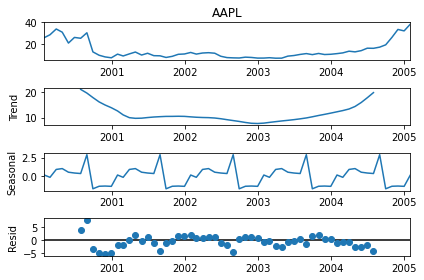

AMZN 



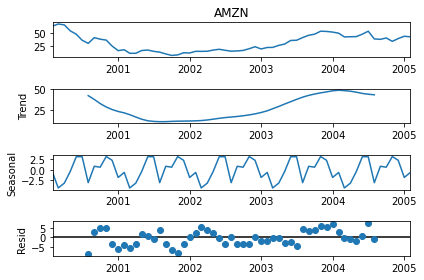

IBM 



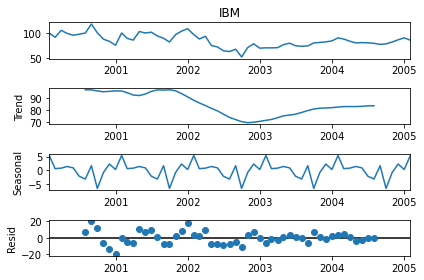

MSFT 



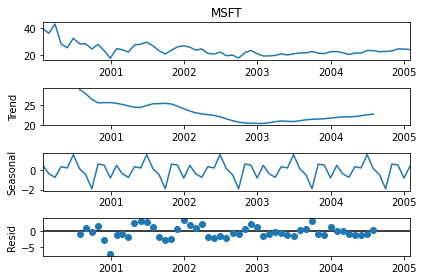

In [42]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

# Basic Holt's Linear Trend

**Make Predictions**

In [46]:
model = Holt(train['AMZN'], exponential=False)
model = model.fit(optimized=True)
yhat_items = model.predict(start = validate.index[0],
                            end = validate.index[-1])
yhat_df['AMZN'] = yhat_items

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [47]:
yhat_df.head()

,AAPL,IBM,AMZN,MSFT
date,,,,
2005-02-01,13.762333,78.791333,43.497586,21.713667
2005-03-01,13.762333,78.791333,43.775173,21.713667
2005-04-01,13.762333,78.791333,44.052759,21.713667
2005-05-01,13.762333,78.791333,44.330345,21.713667
2005-06-01,13.762333,78.791333,44.607932,21.713667


In [49]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)
    

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  """
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7

In [50]:
yhat_df.head()

,AAPL,IBM,AMZN,MSFT
date,,,,
2005-02-01,23.01,86.04,53.17,24.46
2005-03-01,24.14,86.55,54.36,24.65
2005-04-01,25.26,87.07,55.55,24.85
2005-05-01,26.39,87.58,56.74,25.04
2005-06-01,27.51,88.09,57.93,25.24


AAPL -- RMSE: 55


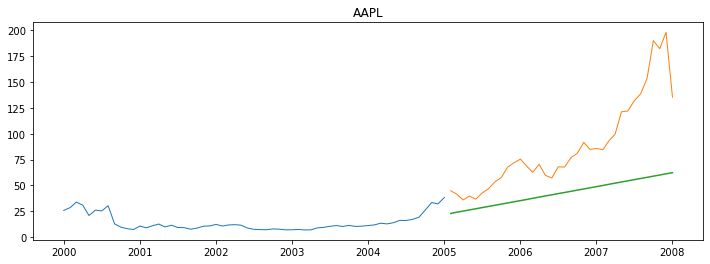

AMZN -- RMSE: 28


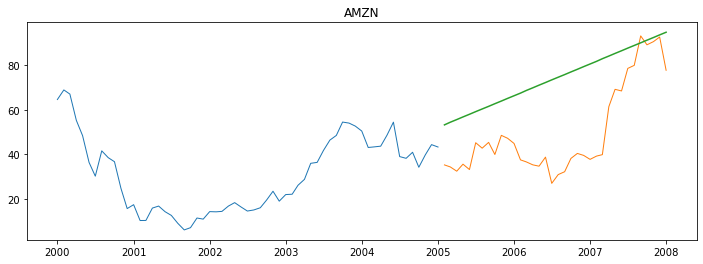

IBM -- RMSE: 13


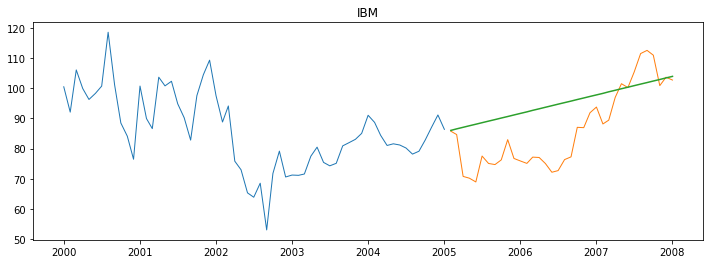

MSFT -- RMSE: 3


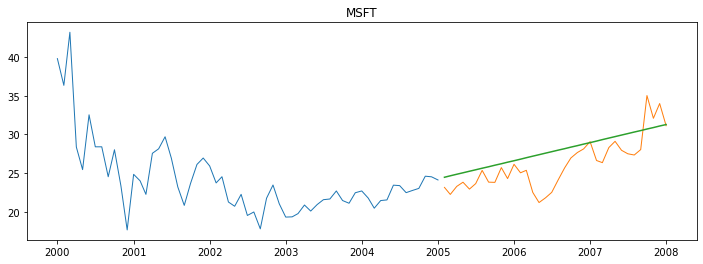

In [51]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [52]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized', 
                             target_var = col)

In [54]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
19,Holts_optimized,MSFT,3.0
3,last_observed_value,MSFT,4.0
7,simple_average,MSFT,4.0
15,30d moving average,MSFT,6.0
11,30d moving average,MSFT,6.0
2,last_observed_value,IBM,13.0
6,simple_average,IBM,13.0
18,Holts_optimized,IBM,13.0
14,30d moving average,IBM,15.0
10,30d moving average,IBM,15.0


- Let's do another model, changing some hyperparameters

In [55]:
for col in train.columns:
    model = Holt(train[col], exponential = False, damped=True)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  """
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py

AAPL -- RMSE: 73


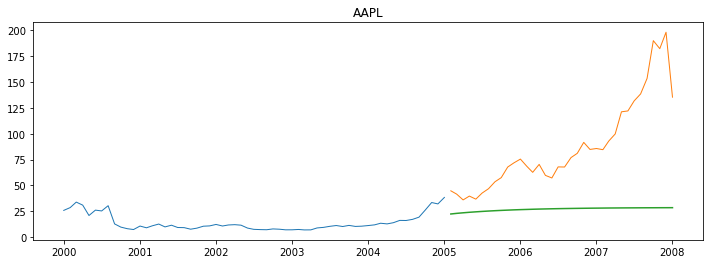

AMZN -- RMSE: 21


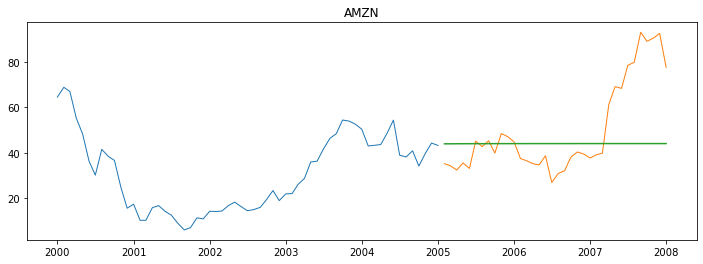

IBM -- RMSE: 13


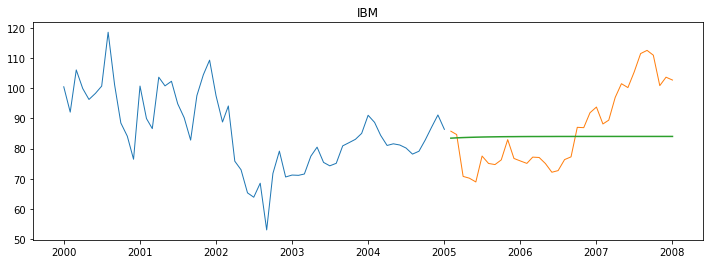

MSFT -- RMSE: 4


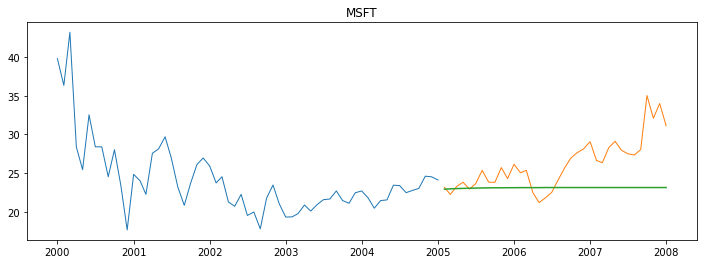

In [56]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [59]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized_damped', 
                             target_var = col)

In [60]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
19,Holts_optimized,MSFT,3.0
27,Holts_optimized_damped,MSFT,4.0
3,last_observed_value,MSFT,4.0
23,Holts_optimized,MSFT,4.0
7,simple_average,MSFT,4.0
11,30d moving average,MSFT,6.0
15,30d moving average,MSFT,6.0
26,Holts_optimized_damped,IBM,13.0
22,Holts_optimized,IBM,13.0
2,last_observed_value,IBM,13.0


In [63]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .5, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  """
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7

AAPL -- RMSE: 20


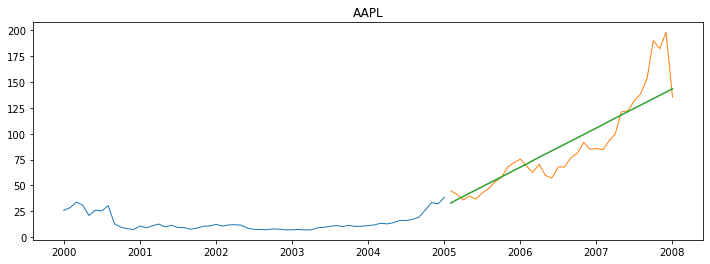

AMZN -- RMSE: 73


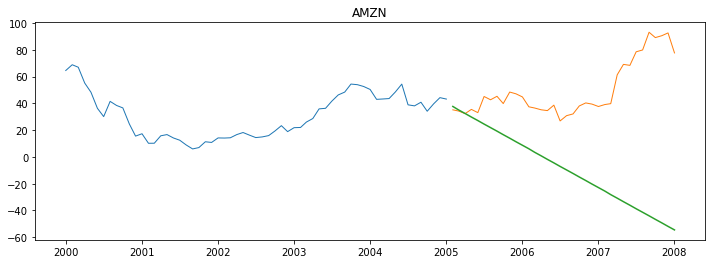

IBM -- RMSE: 48


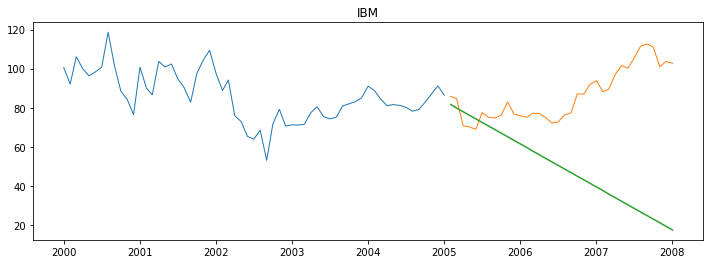

MSFT -- RMSE: 4


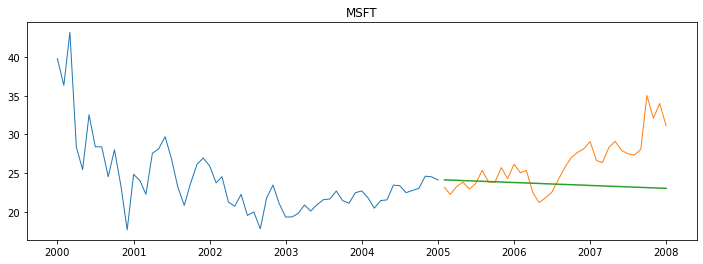

In [64]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [65]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized_change_weight', 
                             target_var = col)

In [67]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
19,Holts_optimized,MSFT,3.0
31,Holts_optimized_change_weight,MSFT,4.0
27,Holts_optimized_damped,MSFT,4.0
23,Holts_optimized,MSFT,4.0
3,last_observed_value,MSFT,4.0
7,simple_average,MSFT,4.0
11,30d moving average,MSFT,6.0
15,30d moving average,MSFT,6.0
18,Holts_optimized,IBM,13.0
26,Holts_optimized_damped,IBM,13.0


# Predict Based on Previous Cycle

**Re-Split data**

In [106]:
train = df[:'2006']
validate = df['2007']
test = df['2009']

print(train.shape)
print(validate.shape)
print(test.shape)

(84, 4)
(12, 4)
(12, 4)


**Make Predictions**

In [110]:
train.diff(12).mean()

symbol
AAPL    8.382500
AMZN   -1.279861
IBM    -3.032778
MSFT   -0.819167
dtype: float64

In [111]:
train.head()

symbol,AAPL,AMZN,IBM,MSFT
date,,,,
2000-01-01,25.94,64.56,100.52,39.81
2000-02-01,28.66,68.87,92.11,36.35
2000-03-01,33.95,67.00,106.11,43.22
2000-04-01,31.01,55.19,99.95,28.37
2000-05-01,21.00,48.31,96.31,25.45


In [112]:
yhat_df = train['2006'] + train.diff(12).mean()


In [113]:
pd.concat([yhat_df.head(1), validate.head(1)])


symbol,AAPL,AMZN,IBM,MSFT
date,,,,
2006-01-01,83.8925,43.540139,72.857222,25.320833
2007-01-01,85.7300,37.670000,93.790000,29.070000


In [114]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

12

AAPL -- RMSE: 62


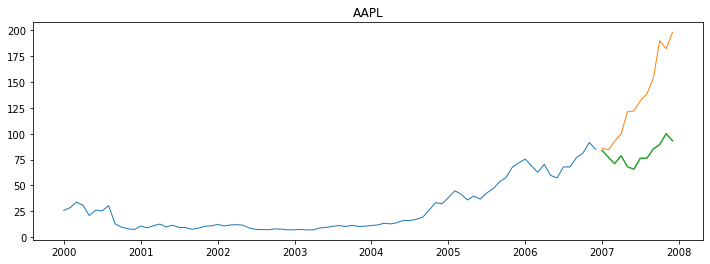

AMZN -- RMSE: 41


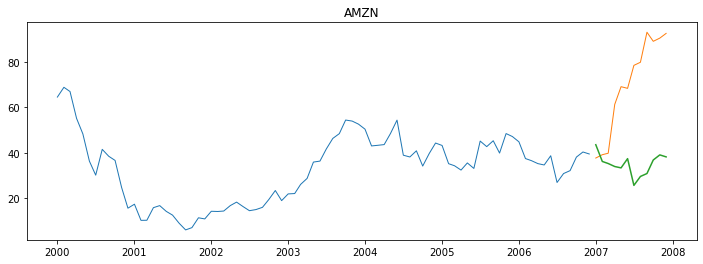

IBM -- RMSE: 27


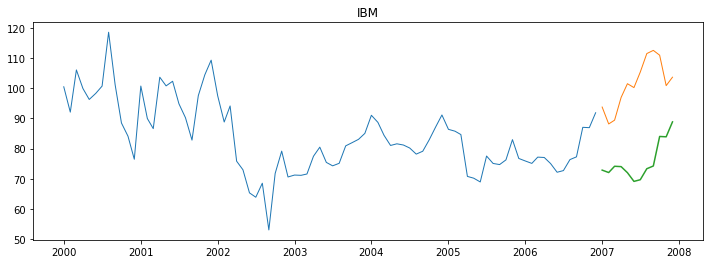

MSFT -- RMSE: 6


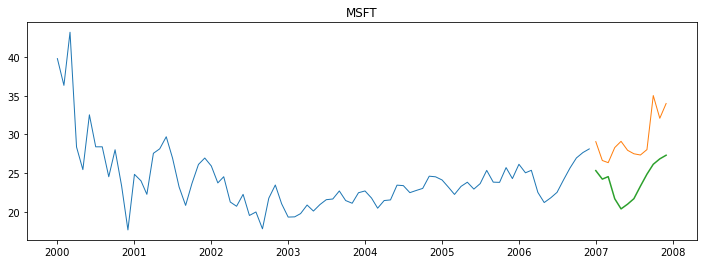

In [115]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [116]:
prime = pd.read_csv("historical_prime rate.csv")

In [117]:
prime.head()

,Year,Average majority prime rate charged by banks,Significant Events
0,1956,3.77,NaN
1,1957,4.20,NaN
2,1958,3.83,NaN
3,1959,4.48,NaN
4,1960,4.82,NaN


In [118]:
prime.shape

(60, 3)

In [119]:
prime = prime[['Year', 'Average majority prime rate charged by banks']]

In [120]:
prime.head()

,Year,Average majority prime rate charged by banks
0,1956,3.77
1,1957,4.20
2,1958,3.83
3,1959,4.48
4,1960,4.82
